In [41]:
import scipy.stats as st
import numpy as np

mu1 = -1
mu2 = 10
sd1 = 2
sd2 = 3
pi_1 = 0.2

k = st.bernoulli(pi_1).rvs(30000)
x1 = st.norm(mu1, sd1).rvs(sum(k==1))
x2 = st.norm(mu2, sd2).rvs(sum(k==0))
x = np.concatenate([x1,x2])

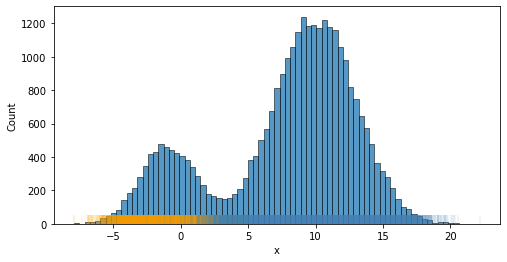

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,4))
sns.histplot(x=x)
plt.vlines(x1, 0, 50, color='orange', alpha=0.1);
plt.vlines(x2, 0, 50, color='steelblue', alpha=0.1);
plt.xlabel('x');

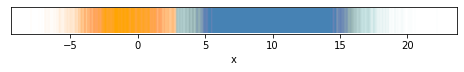

In [43]:
# with known model params, we can estimate z, i.e. which Gaussian did the data come from
norm_factor = pi_1*st.norm(mu1,sd1).pdf(x) + (1-pi_1)*st.norm(mu2,sd2).pdf(x)
pz_1 = pi_1*st.norm(mu1,sd1).pdf(x) / (norm_factor)
pz_2 = (1-pi_1)*st.norm(mu2,sd2).pdf(x) / (norm_factor)

fig = plt.figure(figsize=(8,0.5))
plt.vlines(x[pz_1>0.5], 0, 0.01, color='orange', alpha=0.01);
plt.vlines(x[pz_2>0.5], 0, 0.01, color='steelblue', alpha=0.01);
plt.yticks([]);
plt.xlabel('x');

mu_1: -1.00; sd_1: 2.00; mu_2: 10.00; sd_2: 2.98; pi: 0.20; 


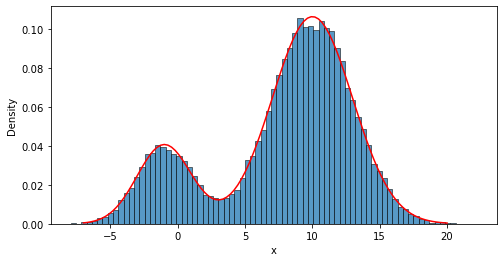

In [44]:
# with known labels, we can estimate the model params
mu1_mle = np.sum(x1)/len(x1)
mu2_mle = np.sum(x2)/len(x2)
sd1_mle = np.std(x1, ddof=0)
sd2_mle = np.std(x2, ddof=0)
pi_est = len(x1)/(len(x1)+len(x2))

print(f'mu_1: {mu1_mle:.2f}; sd_1: {sd1_mle:.2f}; mu_2: {mu2_mle:.2f}; sd_2: {sd2_mle:.2f}; pi: {pi_est:.2f}; ')

t = np.linspace(-7,20,100)
x_est = pi_est*st.norm(mu1_mle, sd1_mle).pdf(t)+(1-pi_est)*st.norm(mu2_mle, sd2_mle).pdf(t)

fig = plt.figure(figsize=(8,4))
plt.plot(t,x_est, color='r')
sns.histplot(x=x, stat='density');
plt.xlabel('x');

mu_1: -0.99; sd_1: 2.02; pi_1: 0.20;
mu_2: 10.01; sd_2: 2.98; pi_2: 0.80;


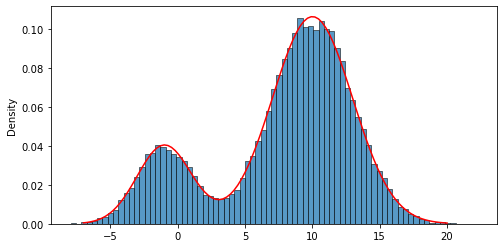

In [47]:
def EM_Gaussian(mu_init, sd_init, pi_init, n_iter=300):
    # EM for Gaussian mixture models
    mu = mu_init
    sd = sd_init
    pi = pi_init
    K = len(pi_init) # number of Gaussians

    for n in range(n_iter):
        # Expectation step
        # calculate responsibilities for each Guassian
        norm_factor = 0
        for mu_k, sd_k, pi_k in zip(mu, sd, pi):
            norm_factor += pi_k*st.norm(mu_k,sd_k).pdf(x)

        pz = [[],[]]
        for k in range(K):
            pz[k] = pi[k]*st.norm(mu[k],sd[k]).pdf(x) / (norm_factor)

        # Maximization step
        # calculate the model params for next step
        for k in range(K):
            mu[k] = np.sum(pz[k]*x) / np.sum(pz[k])
            sd[k] = (np.sum(pz[k]*(x-mu[k])**2) / np.sum(pz[k]))**0.5
            pi[k] = np.sum(pz[k])/len(pz[k])

    return mu, sd, pi

# run EM
mu_est, sd_est, pi_est = EM_Gaussian([0, 0], [1, 1], [0.4, 0.5], n_iter=1000)

# print out estimated params
for mu_k, sd_k, pi_k, k in zip(mu_est, sd_est, pi_est, np.arange(len(pi_est))+1):
    print(f'mu_{k}: {mu_k:.2f}; sd_{k}: {sd_k:.2f}; pi_{k}: {pi_k:.2f};')

# plot results
t = np.linspace(-7,20,100)
x_est = pi_est[0]*st.norm(mu_est[0], sd_est[0]).pdf(t) + pi_est[1]*st.norm(mu_est[1], sd_est[1]).pdf(t)

fig = plt.figure(figsize=(8,4))
plt.plot(t,x_est,color='r')
sns.histplot(x=x, stat='density');